In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import urllib.request
import tarfile
import os
import random

os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Configurations
n_qubits = 8
batch_size = 16
num_epochs = 5
learning_rate = 5e-5
num_repeats = 5  # Число повторов

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ClassicalBERT(nn.Module):
    def __init__(self, bert_model="bert-base-uncased"):
        super().__init__()
        self.bert = AutoModel.from_pretrained(bert_model)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(n_qubits, 2)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids, attention_mask=attention_mask).pooler_output
        bert_output = self.dropout(bert_output[:, :n_qubits])
        return self.fc(bert_output)

# Prepare Data (load only once!)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
filename = 'aclImdb_v1.tar.gz'
if not os.path.exists('aclImdb'):
    urllib.request.urlretrieve(url, filename)
    with tarfile.open(filename, 'r:gz') as tar:
        tar.extractall()
train_data = load_files('aclImdb/train', categories=['pos', 'neg'], encoding='utf-8')

# --- Метрики ---
accuracies, precisions, recalls, f1s = [], [], [], []
train_losses_all, val_losses_all = [], []

def print_mean_std(name, arr):
    print(f"{name}: mean = {np.mean(arr):.4f}, std = {np.std(arr):.4f}")

for repeat in range(num_repeats):
    print(f"\n=== Repeat {repeat + 1}/{num_repeats} ===")
    # --- Случайная выборка 2000 ---
    indices = np.random.choice(len(train_data.data), 2000, replace=False)
    texts = [train_data.data[i] for i in indices]
    labels = [train_data.target[i] for i in indices]
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        texts, labels, test_size=0.2, random_state=random.randint(0, 10000)
    )

    # Токенизация
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128, return_tensors='pt')
    train_labels = torch.tensor(train_labels)
    val_labels = torch.tensor(val_labels)

    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
    val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    # Model, Optimizer, Loss
    model = ClassicalBERT().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # --- Train ---
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for input_ids, attention_mask, labels in train_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_loss:.4f}")
    train_losses_all.append(avg_loss)  # Сохраняем финальный Train Loss для этого запуска

    # --- Evaluation ---
    model.eval()
    preds, truths = [], []
    val_losses = []
    with torch.no_grad():
        for input_ids, attention_mask, labels in val_loader:
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_losses.append(loss.item())
            preds.extend(outputs.argmax(dim=1).cpu().numpy())
            truths.extend(labels.cpu().numpy())

    val_loss_mean = np.mean(val_losses)
    val_losses_all.append(val_loss_mean)

    accuracy = accuracy_score(truths, preds)
    precision, recall, f1, _ = precision_recall_fscore_support(truths, preds, average='binary')
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    print(f'Val Loss: {val_loss_mean:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

# --- Выводим итоговые метрики ---
print("\n==== Statistics over runs ====")
print_mean_std('Train Loss', train_losses_all)
print_mean_std('Val Loss', val_losses_all)
print_mean_std('Accuracy', accuracies)
print_mean_std('Precision', precisions)
print_mean_std('Recall', recalls)
print_mean_std('F1-score', f1s)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


=== Repeat 1/5 ===


2025-05-28 10:23:47.693011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748427827.894234      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748427827.956656      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/5, Train Loss: 0.5591
Epoch 2/5, Train Loss: 0.3565
Epoch 3/5, Train Loss: 0.2233
Epoch 4/5, Train Loss: 0.1830
Epoch 5/5, Train Loss: 0.1438
Val Loss: 0.6171, Accuracy: 0.7400, Precision: 0.6803, Recall: 0.9524, F1-score: 0.7937

=== Repeat 2/5 ===
Epoch 1/5, Train Loss: 0.5859
Epoch 2/5, Train Loss: 0.3365
Epoch 3/5, Train Loss: 0.2566
Epoch 4/5, Train Loss: 0.2024
Epoch 5/5, Train Loss: 0.1556
Val Loss: 0.4655, Accuracy: 0.8200, Precision: 0.8711, Recall: 0.7824, F1-score: 0.8244

=== Repeat 3/5 ===
Epoch 1/5, Train Loss: 0.6236
Epoch 2/5, Train Loss: 0.5899
Epoch 3/5, Train Loss: 0.4941
Epoch 4/5, Train Loss: 0.4378
Epoch 5/5, Train Loss: 0.4502
Val Loss: 0.5165, Accuracy: 0.8150, Precision: 0.7720, Recall: 0.9190, F1-score: 0.8391

=== Repeat 4/5 ===
Epoch 1/5, Train Loss: 0.6021
Epoch 2/5, Train Loss: 0.4677
Epoch 3/5, Train Loss: 0.4137
Epoch 4/5, Train Loss: 0.3154
Epoch 5/5, Train Loss: 0.2997
Val Loss: 0.4458, Accuracy: 0.8250, Precision: 0.8030, Recall: 0.8446, F1-sc

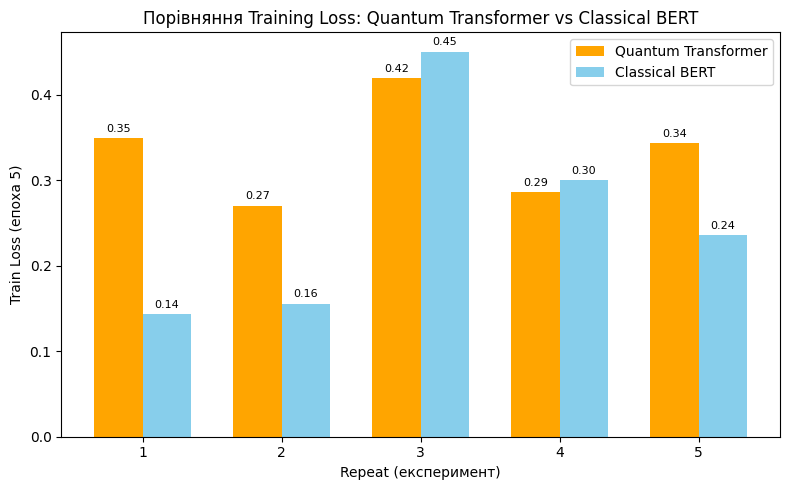

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Training Loss (TrainLoss) із результатів скріншотів
# Quantum Transformer (середні Train Loss по 5 експериментах, епоха 5)
quantum_train_losses = [0.3487, 0.2701, 0.4188, 0.2856, 0.3432]

# Classical BERT (середні Train Loss по 5 експериментах, епоха 5)
classical_train_losses = [0.1438, 0.1556, 0.4502, 0.2997, 0.2357]

x = np.arange(1, 6)  # Номери експериментів
width = 0.35  # ширина стовпчика

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, quantum_train_losses, width, label='Quantum Transformer', color='orange')
rects2 = ax.bar(x + width/2, classical_train_losses, width, label='Classical BERT', color='skyblue')

ax.set_xlabel('Repeat (експеримент)')
ax.set_ylabel('Train Loss (епоха 5)')
ax.set_title('Порівняння Training Loss: Quantum Transformer vs Classical BERT')
ax.set_xticks(x)
ax.legend()

# Додавання підписів на стовпчиках
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}', xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()


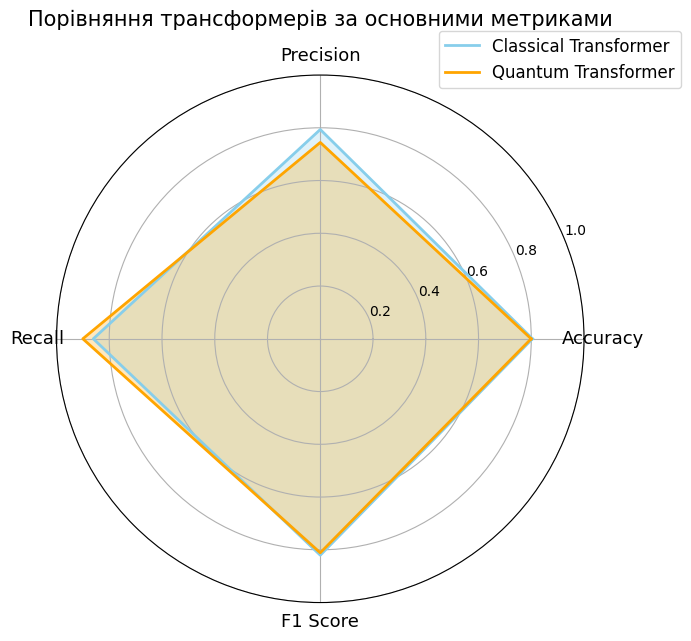

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Початкові унікальні мітки
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Метрики без повторення (4 значення)
classical_metrics = [0.8045, 0.7935, 0.8605, 0.8205]
quantum_metrics = [0.7995, 0.7444, 0.9002, 0.8113]

# Додаємо перший елемент у кінець для замикання кола
classical_metrics.append(classical_metrics[0])
quantum_metrics.append(quantum_metrics[0])

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]  # також додаємо перший кут для замикання кола

fig, ax = plt.subplots(figsize=(7,7), subplot_kw=dict(polar=True))

ax.plot(angles, classical_metrics, color='skyblue', linewidth=2, label='Classical Transformer')
ax.fill(angles, classical_metrics, color='skyblue', alpha=0.25)

ax.plot(angles, quantum_metrics, color='orange', linewidth=2, label='Quantum Transformer')
ax.fill(angles, quantum_metrics, color='orange', alpha=0.25)

# ВАЖЛИВО: встановлюємо унікальні мітки (без повторення!)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=13)

ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2','0.4','0.6','0.8','1.0'])
ax.set_title('Порівняння трансформерів за основними метриками', fontsize=15, pad=15)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1), fontsize=12)

plt.tight_layout()
plt.show()
